<a href="https://colab.research.google.com/github/viriditass/TIL/blob/main/U_Net_Convolutional_Networks_for_Biomedical_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **U-Net: Convolutional Networks for Biomedical Image Segmentation**

논문 링크: https://arxiv.org/abs/1505.04597

데이터셋: http://brainiac2.mit.edu/isbi_challenge/home
1. Register를 눌러 회원가입을 한다.
2. My account를 눌러 로그인을 한다.
3. Downloads를 눌러 아래의 이름으로 된 파일들을 다운받는다.
- ```train-volume.tif (7.5 MB)```
- ```train-labels.tif (7.5 MB)```
- ```test-volume.tif```

U-Net은 주로 **Biomedical** 분야에서 Classfication + Localization으로 활용된다. 이 네트워크는 Image Segmentation을 목적으로 제안된 End-to-End 방식의 **FCN(Fully-Convolutional Network)** 기반 모델이다.

## **U-Net 구조**

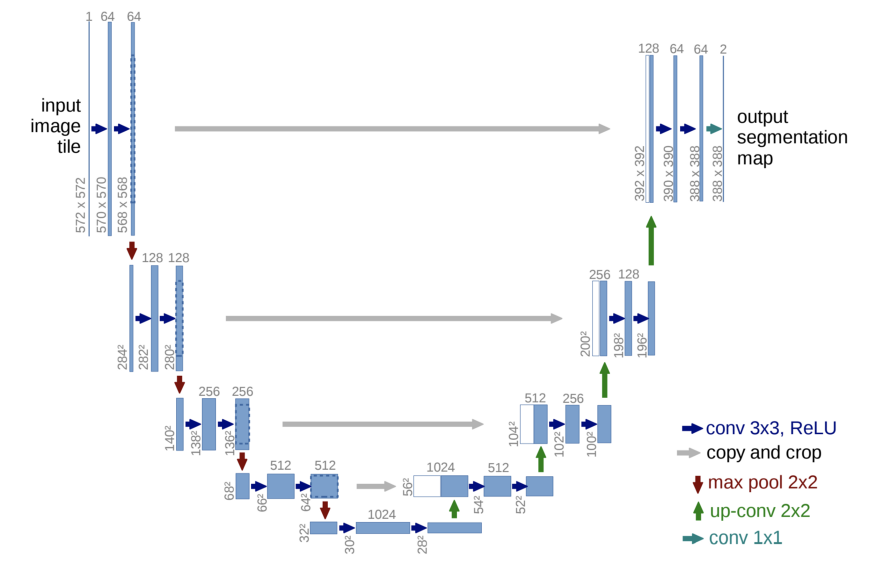

U-Net의 형태는 이름대로 알파벳 'U'와 비슷하게 생겼다. 전반적인 구조는 **Contracting Path (수축 단계)** 와 **Expanding Path (팽창 단계)**로 이루어져 있다. 또한, **Fully Connected Layer**가 없기 때문에 속도측면에서 빠르다.

U-Net의 특이한 점은 바로 U-Net을 가로지르는 회색 선이다. 이 선은 input이 output에 영향을 끼치도록 만든 선인데, **mirror padding**을 진행할때 손실되는 path를 살리기 위하여 contracting path의 데이터를 적당한 크기로 **Crop and Crop**을 사용하여 **Upsampling에 concat**으로 이미지 보상처리를 했다.

### **Patch**

논문에서는 Sliding Window처럼 이미지를 잘라 인식하는 단위를 정했는데 그게 바로 **Patch**이다. 즉, 패치란 쉽게 설명하자면 **이미지 인식 단위**라고 생각하면 된다.

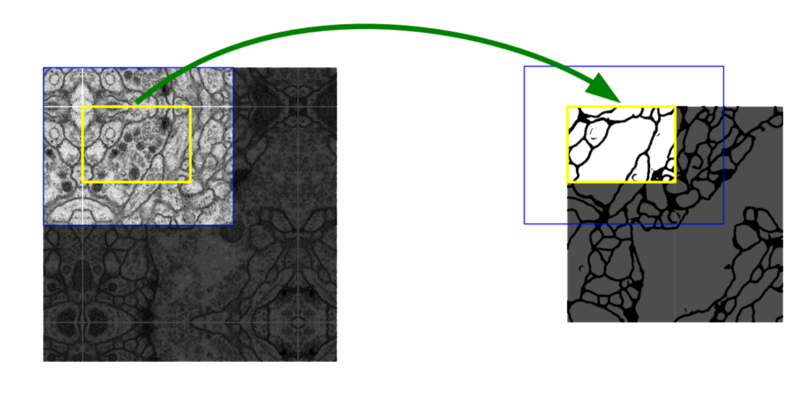

기존 sliding window 방식을 사용하면 이미 사용한 patch 구역을 다음 sliding window에서 또 검증을 하게 된다. 이에 반해 U-Net은 **검증이 끝난 부분은 아예 건너뛰고 다음 patch 부분부터 검증하기 때문에 속도를 개선**할 수 있다.

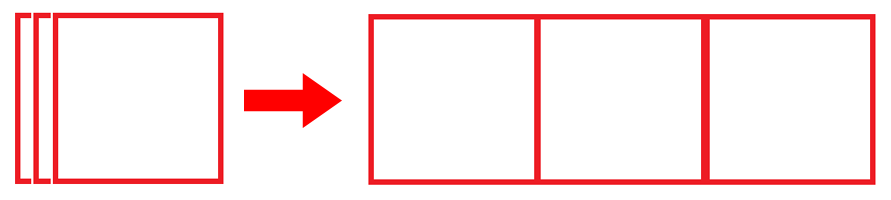

또한, **Trade off**의 높에 빠지지 않는다.

만약 Patch size가 커진다면 더 넓은 이미지를 한번에 인식하기 때문에 Context 인식에는 효과가 있다. 반면 Localization에는 패널티가 생긴다.

반면 Patch size가 작아진다면 Context 인식에는 패널티가 생기지만, Localization에는 효과가 있다.

U-Net은 **여러 Layer의 output을 동시에 검증**하면서 Localization과 Context 인식 두마리 토끼를 다 잡을 수 있다.

### **Mirroring the input image**

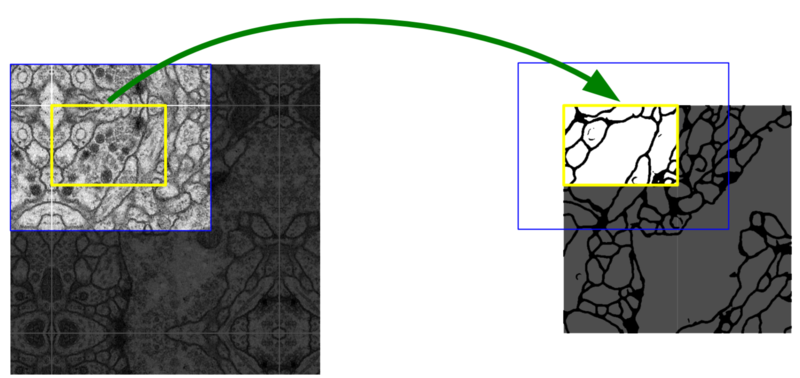

위 이미지는 input image를 U-Net에 통과시켜 나오는 output image와 사이즈 측면에서 비교한 것이다. 논문에선 input image size가 572 x 572인 반면 output image size는 388 x 388이다. 이는 **contracting path에서 padding이 없었기 때문에 외곽 이미지 부분이 없어진** 결과이다.

이를 해결하기 위하여 논문에서는 **mirroring**이라는 것을 택했다.

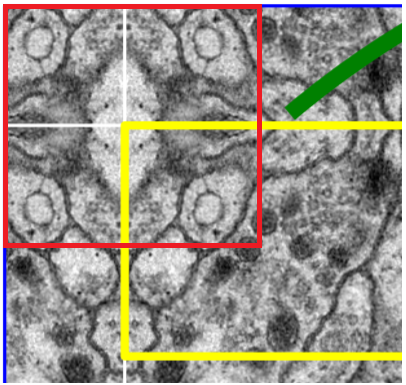

위 이미지는 input image를 확대한 것인데, 보시다 싶이 바깥쪽 없어지는 부분이 안쪽 이미지의 형태와 마치 **거울에 반사된 것**처럼 같다는걸 알 수 있다. 이처럼 사라지는 부분을 **zero-padding**이 아닌 **mirror padding**의 형태로 채워 없어진 부분에 대해 보상을 해준다.

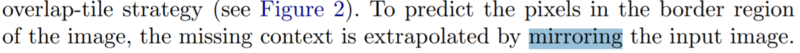

### **Contracting Path & Expanding Path**